In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time, datetime
import data_wrangling as dw

#xgboost = gradientboosted tress
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.svm import LinearSVC

/home/charles/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/charles/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def time_mask(df, key = 'Proc.Start.Date', value = '01/01/08'):
    t = time.mktime(datetime.datetime.strptime(value,'%d/%m/%y').timetuple())
    return df[key] >= t

In [3]:
def split_df(df):
    #mask = time_mask(df)
    
    #finalDf_train = df[-mask] # training 6000
    #finalDf_test = df[mask]   # training2 cros validation
    
    idx_val = pd.read_csv("data/training2_ids.csv")
    idx_holdout = pd.read_csv("data/testing_ids.csv")
    
    finalDf_test = df.loc[idx_val["ids"],:]
    #finalDf_train = munged.loc[~(munged.index).isin(idx_val["ids"])]
    finalDf_train = df.loc[(~(munged.index).isin(idx_val["ids"])) & (~(munged.index).isin(idx_holdout["ids"]))] 

    #creating X, y splits for test and train dataframes
    y_train = finalDf_train['Grant.Status'].values
    del finalDf_train['Grant.Status']
    del finalDf_train['Start.date']
    X_train = finalDf_train.values

    y_test = finalDf_test['Grant.Status'].values
    del finalDf_test['Grant.Status']
    del finalDf_test['Start.date']
    X_test = finalDf_test.values

    return X_train, y_train, X_test, y_test, finalDf_test, finalDf_train

In [4]:
def dataset_holdout(df):
    idx_holdout = pd.read_csv("data/testing_ids.csv")
    finalDf_holdout = df.loc[idx_holdout["ids"],:]
    
    y_holdout = finalDf_holdout['Grant.Status'].values
    del finalDf_holdout['Grant.Status']
    del finalDf_holdout['Start.date']
    X_holdout = finalDf_holdout.values

    return X_holdout, y_holdout

In [5]:
orig = dw.get_tables()
munged = dw.munge_data(orig)
X_train, y_train, X_test, y_test, finalDf_test, finalDf_train = split_df(munged)
X_holdout, y_holdout = dataset_holdout(munged)

/home/charles/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (90,105,119,120,123,124,132,134,135,138,139,147,149,150,153,154,162,164,165,168,169,177,179,183,184,192,194,198,199,207,209,213,214,224,237,239,244) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/charles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (90,105,119,120,123,124,132,134,135,138,139,147,149,150,153,154,162,164,165,168,169,177,179,183,184,192,194,198,199,207,209,213,214,224,237,239,244) have mixed types. Specify dtype option on import or set low_memory=False.
  


ValueError: cannot reindex from a duplicate axis

In [34]:
def training(X, y, X_test = None, y_test = None, a = None):
    if(a != None):
        train_labels = np.arange(X.shape[0])
        test_labels = np.arange(X_test.shape[0]) + X.shape[0]
        X = np.concatenate((X, X_test), axis = 0)
        y = np.concatenate((y, y_test), axis = 0)
        cv_custom = [(train_labels, test_labels)]
    estimators = [
            ('scale_predictors', StandardScaler()),
            #('feature_selector', LinearSVC(penalty='l1', dual=False)),
            #('feature_selector', SelectKBest(score_func=f_classif)),
            #('linearSVC', LinearSVC())
            ('randomforests', RandomForestClassifier())
            ]
    clf = Pipeline(estimators)
    params = dict(
            #linearSVC__C=[0.1, 1, 10],
            randomforests__max_depth=[5, 10, None], 
            randomforests__n_estimators=[10, 50, 100,1000,10000], 
            #feature_selector__C=[0.1, 1, 10]
            #feature_selector__score_func=[chi2],
            #feature_selector__k=[5, 10, 'all'] 
            )
    if(a != None):
        grid_search = GridSearchCV(clf, param_grid=params, cv=cv_custom, scoring = 'roc_auc', n_jobs = 6)
    else:
        grid_search = GridSearchCV(clf, param_grid=params, scoring = 'roc_auc', n_jobs = 6)
    grid_search.fit(X, y)
    return grid_search

In [35]:
def performance(results, param1, param2):
    param1_vals = [x.parameters[param1] for x in results.grid_scores_]
    param2_vals = [x.parameters[param2] for x in results.grid_scores_]
    means = [x.mean_validation_score for x in results.grid_scores_]
    df = pd.DataFrame(list(zip(param1_vals, param2_vals, means)), columns = [param1, param2, 'means'])
    df.fillna('None', inplace=True)
    return pd.pivot_table(df, values = 'means' , index = param1, columns = param2)

In [9]:
%matplotlib inline

%pylab

import matplotlib.pyplot as plt

plt.close('all')
pylab.rcParams['figure.figsize'] = (30.0, 30.0)

offset = 12*0
n = 24
cols = 3
myrange = finalDf_train.columns[list(range(6))+list(range(10, 14))+list(range(15, 20))+[37, 38, 42, 58, 63, 68, 69, 70, 76]]
fig, sbp = plt.subplots(n//cols, cols)
fig.tight_layout()
for i, l in enumerate(myrange[offset:offset+n]):
    #print(i,l)
    sbp[i //cols][i % cols].set_title('{}: '.format(i+offset)+l, size=30)
    finalDf_train[l].hist(ax=sbp[i //cols ][i % cols], bins = 30)

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [36]:
#model_on_train = training(X_train, y_train)
model_on_train = training(X_train, y_train, X_test=X_test, y_test=y_test, a = 2)
model_on_train.best_score_
#model_on_test.best_score_
a = list(model_on_train.param_grid)
train_results = performance(model_on_train, a[0],  a[1])
#a = list(model_on_test.param_grid)
#test_results = performance(model_on_test, a[0],  a[1])
print(train_results)
#print(test_results)
# can only take 2 variables for our pivot table

randomforests__n_estimators     10        50        100       1000      10000
randomforests__max_depth                                                     
5.0                          0.821367  0.876418  0.882632  0.884553  0.884658
10.0                         0.858722  0.904861  0.906519  0.908554  0.907692
None                         0.859024  0.903889  0.904957  0.910108  0.909989


In [37]:
y_pred = model_on_train.best_estimator_.predict(X_holdout)
y_score = model_on_train.best_estimator_.predict_proba(X_holdout)
np.sum(y_holdout == y_pred)/len(y_holdout)
#y_score[:,1].ravel()

0.86486486486486491

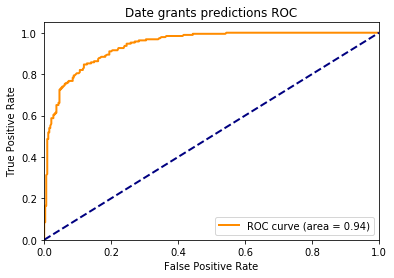

In [38]:
from sklearn.metrics import roc_curve, auc
%matplotlib inline

fpr, tpr, thd = roc_curve(y_holdout.ravel(), y_score[:,1].ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Date grants predictions ROC')
plt.legend(loc="lower right")
plt.show()

In [23]:
idx_val = pd.read_csv("data/training2_ids.csv")
idx_holdout = pd.read_csv("data/testing_ids.csv")
df_val.shape, df_holdout.shape,

((1557, 1), (518, 1))

In [81]:
idx_val.head()
#munged.index in idx_val["ids"]
#munged.head.iloc[munged.I]
#idx_rest = (munged.index).remove(1

,ids
0,6634
1,6635
2,6636
3,6637
4,6638


In [46]:
munged.shape
#munged.head()
#munged.iloc[[0,1]]

(8708, 79)

In [116]:
df_test = munged.loc[idx_val["ids"],:]
df_train = munged.loc[(~(munged.index).isin(idx_val["ids"])) & (~(munged.index).isin(idx_holdout["ids"]))] 
df_holdout = munged.loc[idx_holdout["ids"],:]
df_train.shape, df_holdout.shape, df_test.shape, munged.shape

((6633, 79), (518, 79), (1557, 79), (8708, 79))

In [92]:
df_train = munged.loc[idx_val["ids"],:]

In [95]:
(munged.index).isin(idx_val["ids"])

array([False, False, False, ..., False, False,  True], dtype=bool)

In [103]:
tmp = munged.loc[~(munged.index).isin(idx_val["ids"])]

In [104]:
munged.shape, tmp.shape, idx_val.shape

((8708, 79), (7151, 79), (1557, 1))